In [19]:
import re
import random
import pandas as pd
import hashlib

In [20]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [21]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure Functions + Visual Studio,81.539237,5.824231,14
Vocab,126.286805,11.480619,11
Audit Report Tracker (Sharepoint List),184.018933,11.501183,16
Debugging in VS Code,318.868020,13.863827,23
Powershell Modules,576.837841,19.227928,30
OData,839.976610,59.998329,14
Logging in Python,894.914116,35.796565,25
PP365,945.931266,118.241408,8
Taxes,1101.158019,122.350891,9
Azure AI Search,1176.253465,84.018105,14


# Histogram

45617.04


<Axes: >

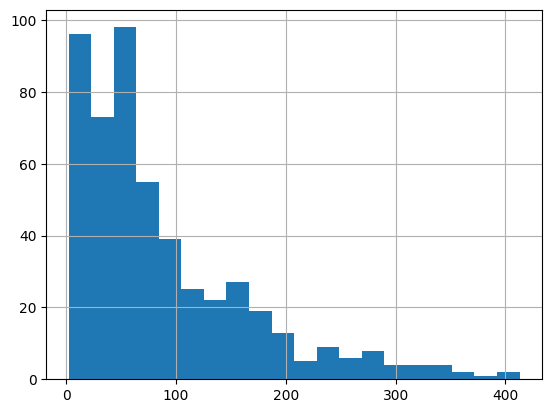

In [22]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [23]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [24]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [25]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [26]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [27]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [28]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [30]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [31]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [32]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [33]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [34]:
n=3
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 512


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,PP365,I had a ticket with Lauren Kawamoto going back...,df019710fcf9dfdc9f4c2beadb6569aa,-234.502585,-118.241408,234.502585,945.931266,0.536100,8,0,0
3,PP365,CORS (Cross-Origin Resource Sharing)\nA securi...,045b8f27d3b503deb8ccdb3db5db0254,-179.503331,-118.241408,234.502585,945.931266,0.536100,8,1,0
80,PP365,API Management (APIM)\nA fully managed Azure s...,5492ec02e5f66fbe13f0d74a2fcf39da,-137.675858,-118.241408,234.502585,945.931266,0.536100,8,2,0
1,Taxes,Pass-Through Entities (PTEs) include business ...,efe9253ba59b32186ea99423d7c0bc3e,-200.945193,-122.350891,200.945193,1101.158019,0.148152,9,0,0
2,Taxes,Quarterly Due Dates: Pass-Through Entities (PT...,ecdb44b3a90bacbc1f6b978b9c7f88f9,-181.044475,-122.350891,200.945193,1101.158019,0.148152,9,1,0
4,Taxes,Reporting Threshold: The aggregate value of fo...,60de2b480437f20ab7f5da5562872d45,-148.382876,-122.350891,200.945193,1101.158019,0.148152,9,2,0
5,Search Engine Optimization,A backlink is an incoming hyperlink from one w...,fb4dd01097043043ba9450188b8830f9,-352.877295,-132.693272,352.877295,1459.625995,0.004635,11,0,0
6,Search Engine Optimization,Link building is the practice of acquiring bac...,0016cbf46227a4d7dfbe421b0ff4d8b8,-278.355173,-132.693272,352.877295,1459.625995,0.004635,11,1,0
7,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-192.256450,-132.693272,352.877295,1459.625995,0.004635,11,2,0
9,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,-17.782277,-11.480619,17.782277,126.286805,0.042708,11,0,0


In [35]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,PP365,I had a ticket with Lauren Kawamoto going back...,df019710fcf9dfdc9f4c2beadb6569aa,-234.502585,-118.241408,234.502585,945.931266,0.536100,8,0,0
3,PP365,CORS (Cross-Origin Resource Sharing)\nA securi...,045b8f27d3b503deb8ccdb3db5db0254,-179.503331,-118.241408,234.502585,945.931266,0.536100,8,1,0
80,PP365,API Management (APIM)\nA fully managed Azure s...,5492ec02e5f66fbe13f0d74a2fcf39da,-137.675858,-118.241408,234.502585,945.931266,0.536100,8,2,0
1,Taxes,Pass-Through Entities (PTEs) include business ...,efe9253ba59b32186ea99423d7c0bc3e,-200.945193,-122.350891,200.945193,1101.158019,0.148152,9,0,0
2,Taxes,Quarterly Due Dates: Pass-Through Entities (PT...,ecdb44b3a90bacbc1f6b978b9c7f88f9,-181.044475,-122.350891,200.945193,1101.158019,0.148152,9,1,0
4,Taxes,Reporting Threshold: The aggregate value of fo...,60de2b480437f20ab7f5da5562872d45,-148.382876,-122.350891,200.945193,1101.158019,0.148152,9,2,0
5,Search Engine Optimization,A backlink is an incoming hyperlink from one w...,fb4dd01097043043ba9450188b8830f9,-352.877295,-132.693272,352.877295,1459.625995,0.004635,11,0,0
6,Search Engine Optimization,Link building is the practice of acquiring bac...,0016cbf46227a4d7dfbe421b0ff4d8b8,-278.355173,-132.693272,352.877295,1459.625995,0.004635,11,1,0
7,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-192.256450,-132.693272,352.877295,1459.625995,0.004635,11,2,0
9,Vocab,Palimpsest\nnoun\nSPA: PAL-imps-est\nIPA: /ˈpæ...,83dd5618c76e96fde6405f55d07dbe7d,-17.782277,-11.480619,17.782277,126.286805,0.042708,11,0,0


In [36]:
existing_cards.head(10)['age'].sum()

np.float64(-1923.3255130686184)